### K-Means with Oversampling and Dimensionality Reduction.

C:\Users\samhi\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


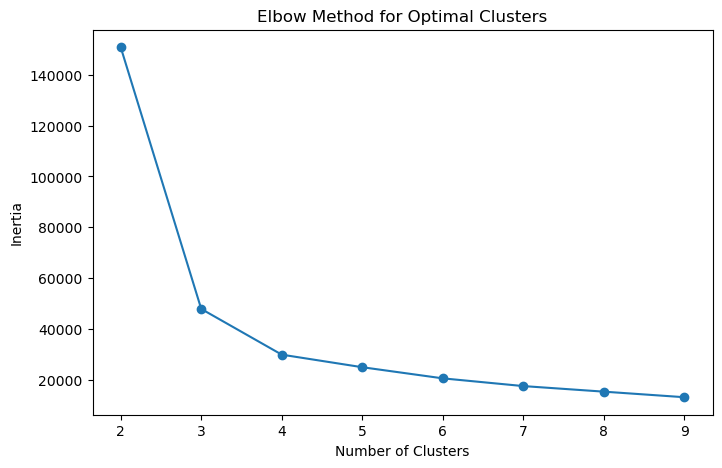

Clustering Metrics:
Silhouette Score: 0.61
Calinski-Harabasz Index: 23774.05
Davies-Bouldin Index: 0.59


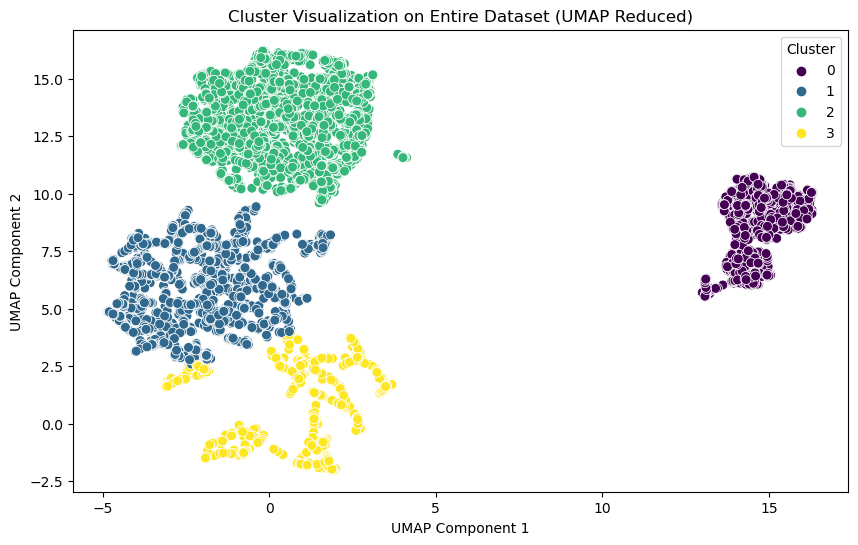

In [13]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import umap
from imblearn.over_sampling import ADASYN

# Load the dataset
data = pd.read_csv('cleaned_train.csv')

# Step 1: Filter out "Adult" category
data = data[data['age_group'] != 'Adult']

# Step 2: Ordinal encode the 'age_group' column
ordinal_encoder = OrdinalEncoder(categories=[['Child', 'Early Teen', 'Teen', 'Young Adult']])
data['age_group'] = ordinal_encoder.fit_transform(data[['age_group']])

# Drop unnecessary columns
columns_to_drop = ['id', 'sii']  # Remove unnecessary columns
data_numeric = data.drop(columns=columns_to_drop, axis=1)

# Split into features and target
X = data_numeric
y = data['sii']  # Use 'sii' for oversampling

# Step 3: Apply ADASYN for Oversampling
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# Step 4: Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Step 5: UMAP for Dimensionality Reduction
umap_model = umap.UMAP(n_components=2, random_state=42)  # Reduce to 2 components
X_umap = umap_model.fit_transform(X_scaled)

# Step 6: Determine Optimal Clusters using the Elbow Method
inertia = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_umap)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Optimal number of clusters based on elbow curve
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)

# Step 7: Fit K-Means on the entire dataset
kmeans.fit(X_umap)
clusters = kmeans.labels_

# Step 8: Evaluate Clustering Performance
silhouette = silhouette_score(X_umap, clusters)
calinski_harabasz = calinski_harabasz_score(X_umap, clusters)
davies_bouldin = davies_bouldin_score(X_umap, clusters)



# Print Metrics
print(f"Clustering Metrics:")
print(f"Silhouette Score: {silhouette:.2f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.2f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.2f}")


# Step 9: Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=clusters, palette='viridis', s=50)
plt.title('Cluster Visualization on Entire Dataset (UMAP Reduced)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Cluster')
plt.show()


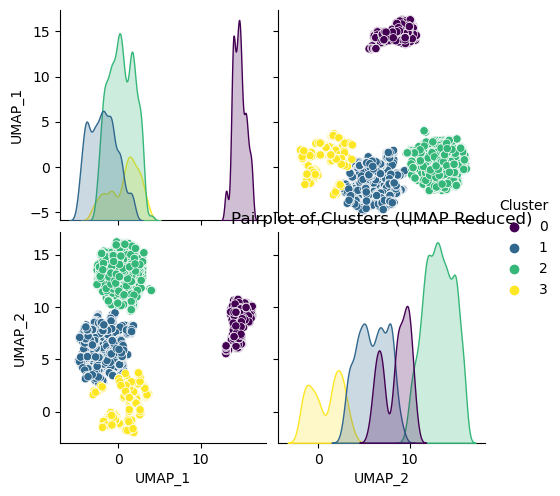

In [15]:
# Combine UMAP components and cluster labels
umap_df = pd.DataFrame(X_umap, columns=['UMAP_1', 'UMAP_2'])
umap_df['Cluster'] = clusters

# Pairplot for visualizing distributions and relationships
sns.pairplot(umap_df, hue='Cluster', palette='viridis', diag_kind='kde')
plt.title('Pairplot of Clusters (UMAP Reduced)')
plt.show()


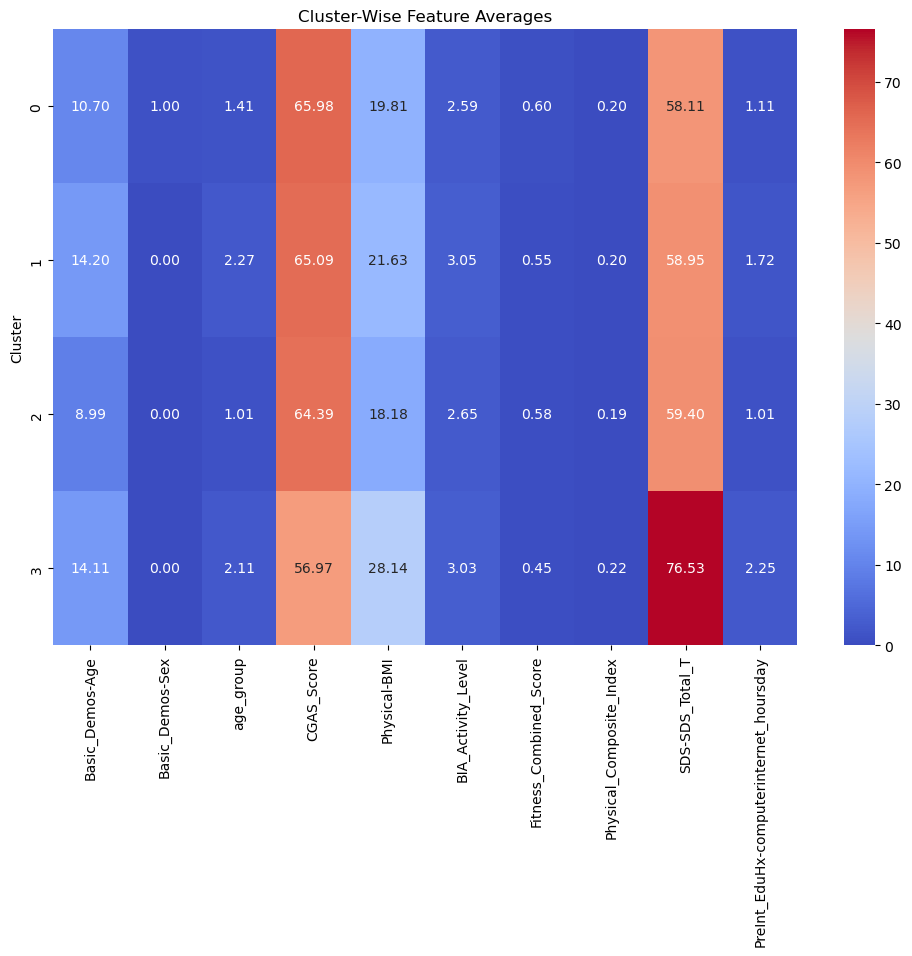

In [16]:
clustered_data = pd.DataFrame(X_resampled, columns=data_numeric.columns)
clustered_data['Cluster'] = clusters

# Compute mean feature values per cluster
cluster_means = clustered_data.groupby('Cluster').mean()

# Plot a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means, cmap='coolwarm', annot=True, fmt='.2f', cbar=True)
plt.title('Cluster-Wise Feature Averages')
plt.show()

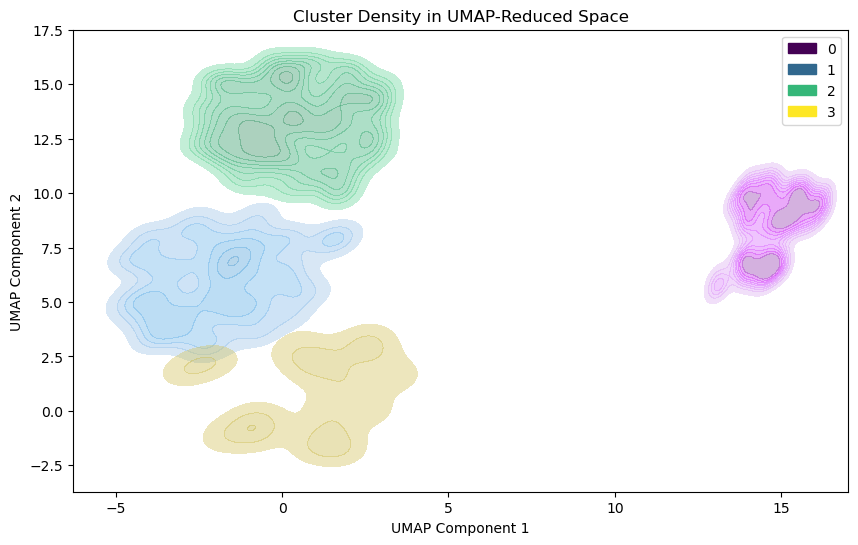

In [17]:
plt.figure(figsize=(10, 6))
sns.kdeplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=clusters, palette='viridis', fill=True, alpha=0.4)
plt.title('Cluster Density in UMAP-Reduced Space')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

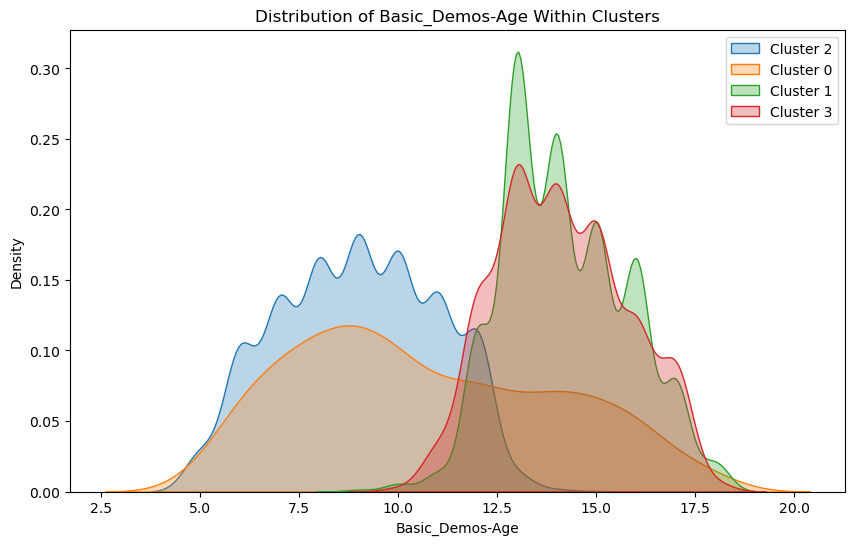

C:\Users\samhi\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\samhi\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


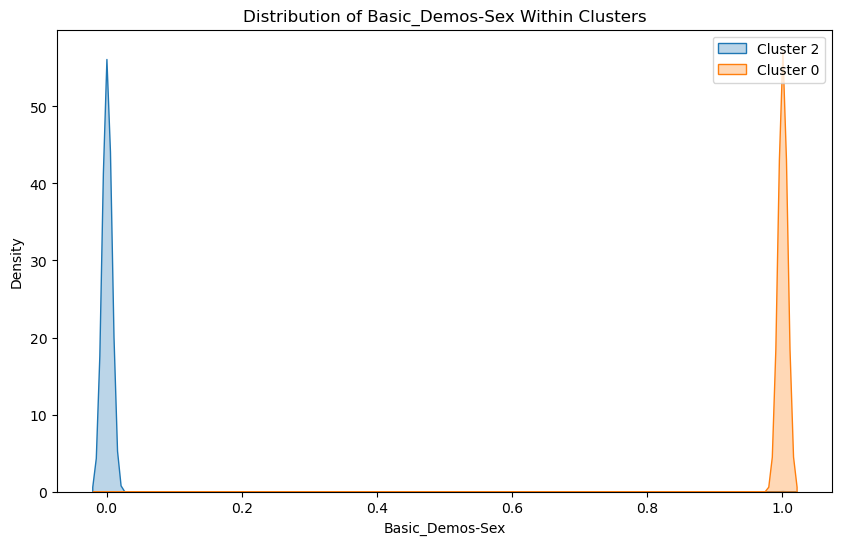

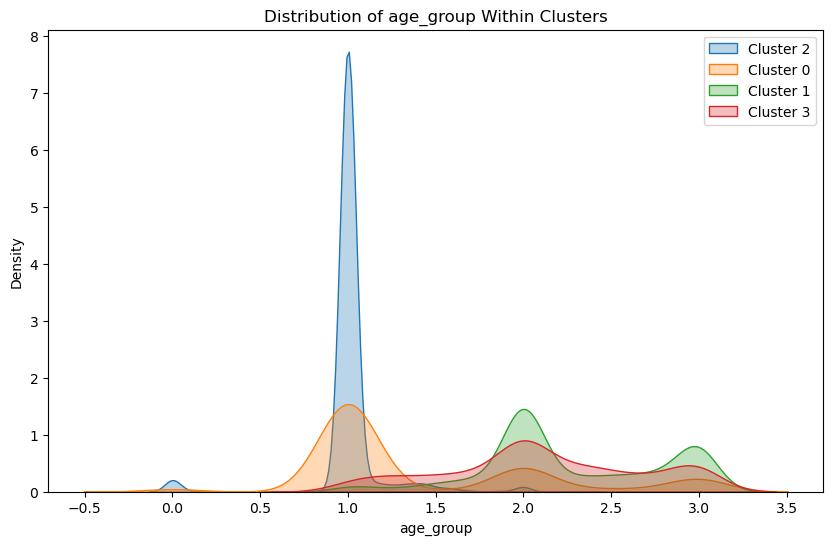

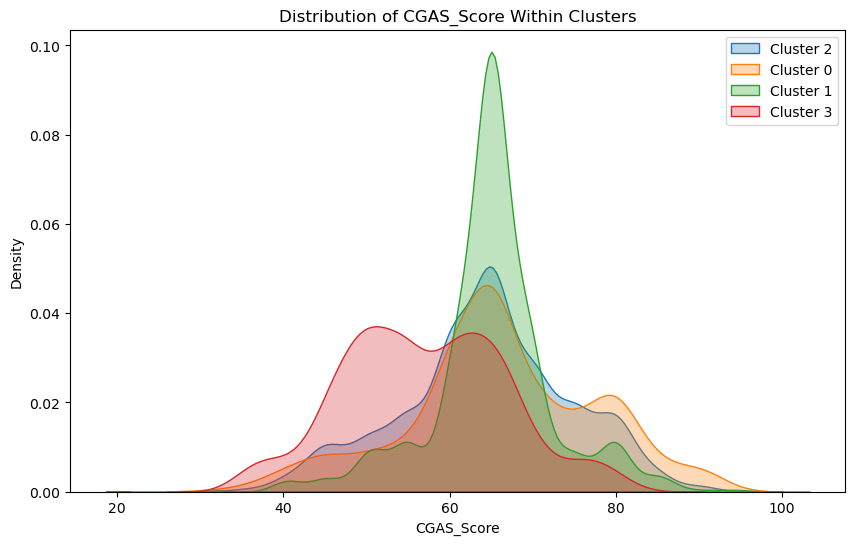

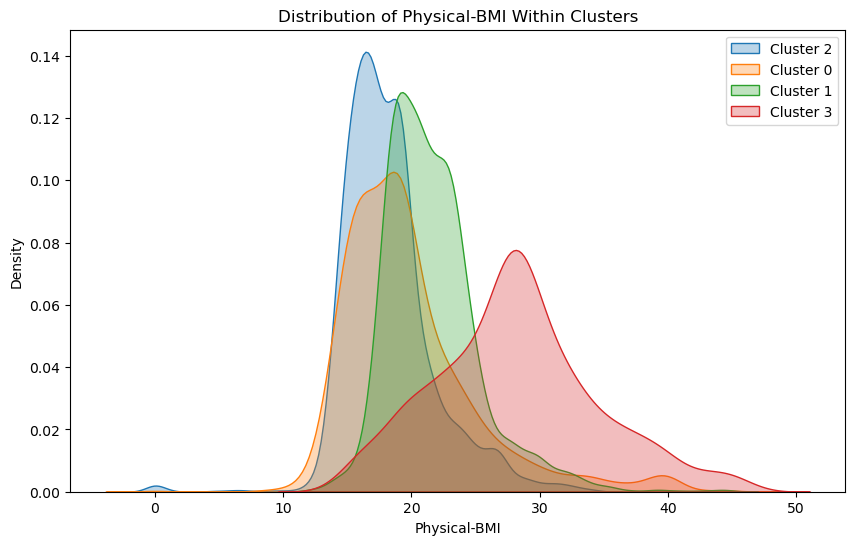

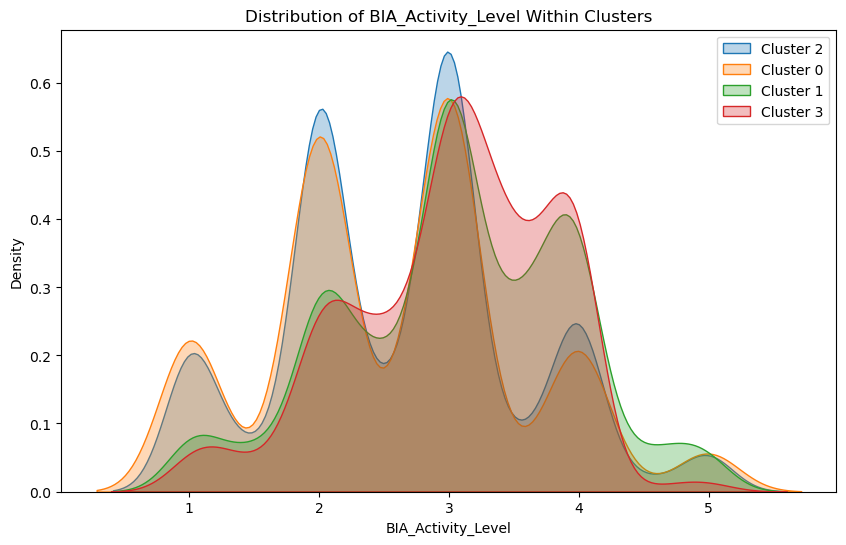

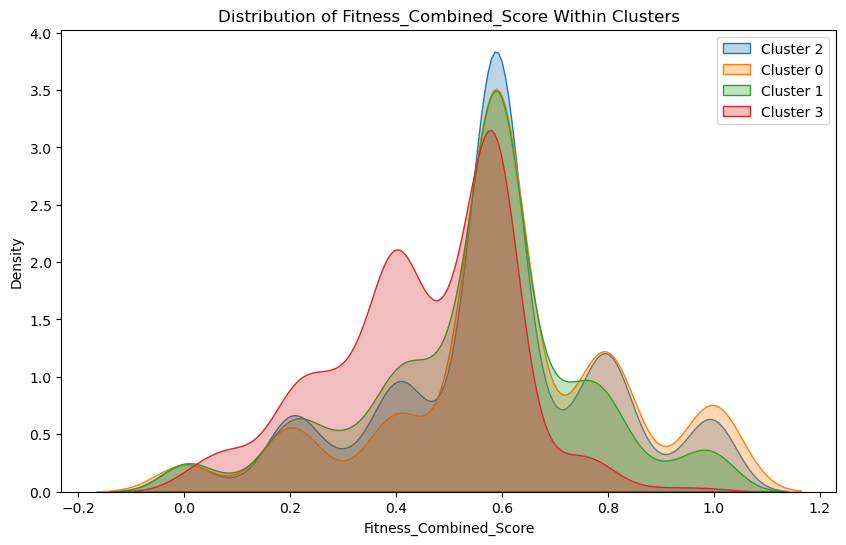

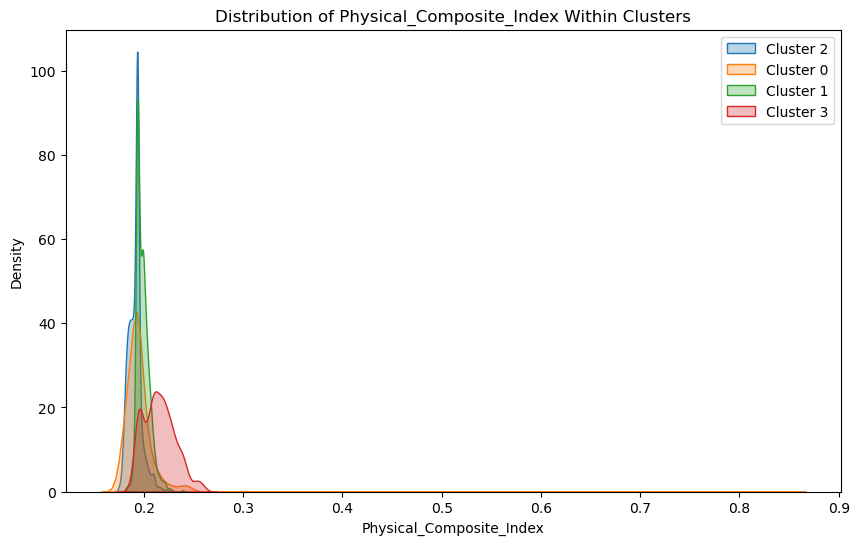

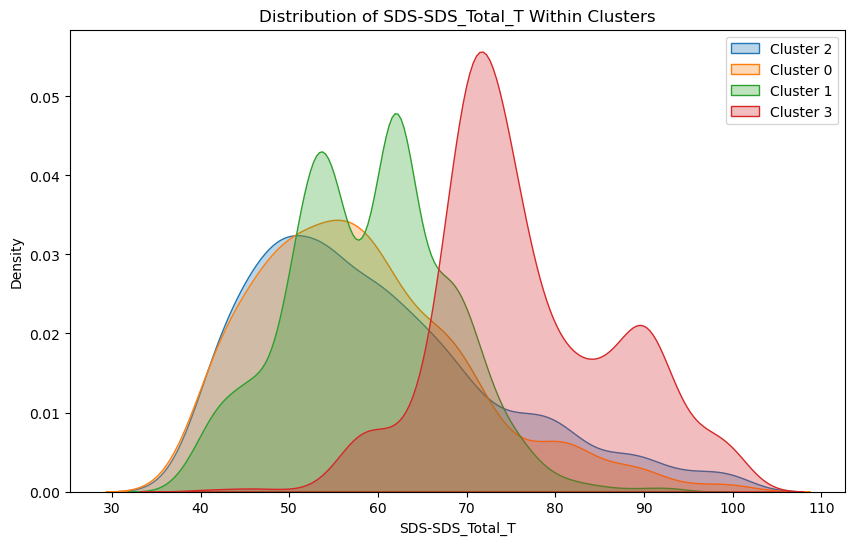

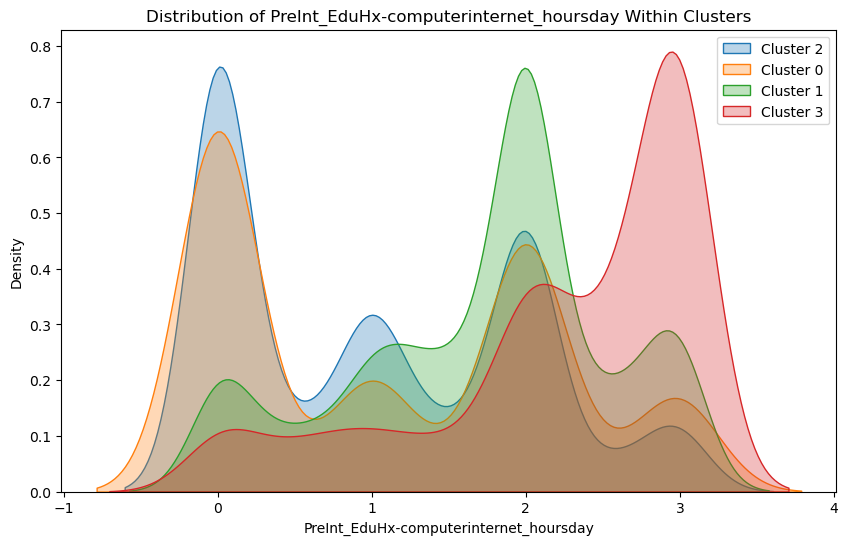

In [19]:
# Plot KDE for each feature within each cluster
for feature in data_numeric.columns:
    plt.figure(figsize=(10, 6))
    for cluster in clustered_data['Cluster'].unique():
        sns.kdeplot(
            clustered_data[clustered_data['Cluster'] == cluster][feature], 
            label=f'Cluster {cluster}', 
            fill=True, alpha=0.3
        )
    plt.title(f'Distribution of {feature} Within Clusters')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.show()


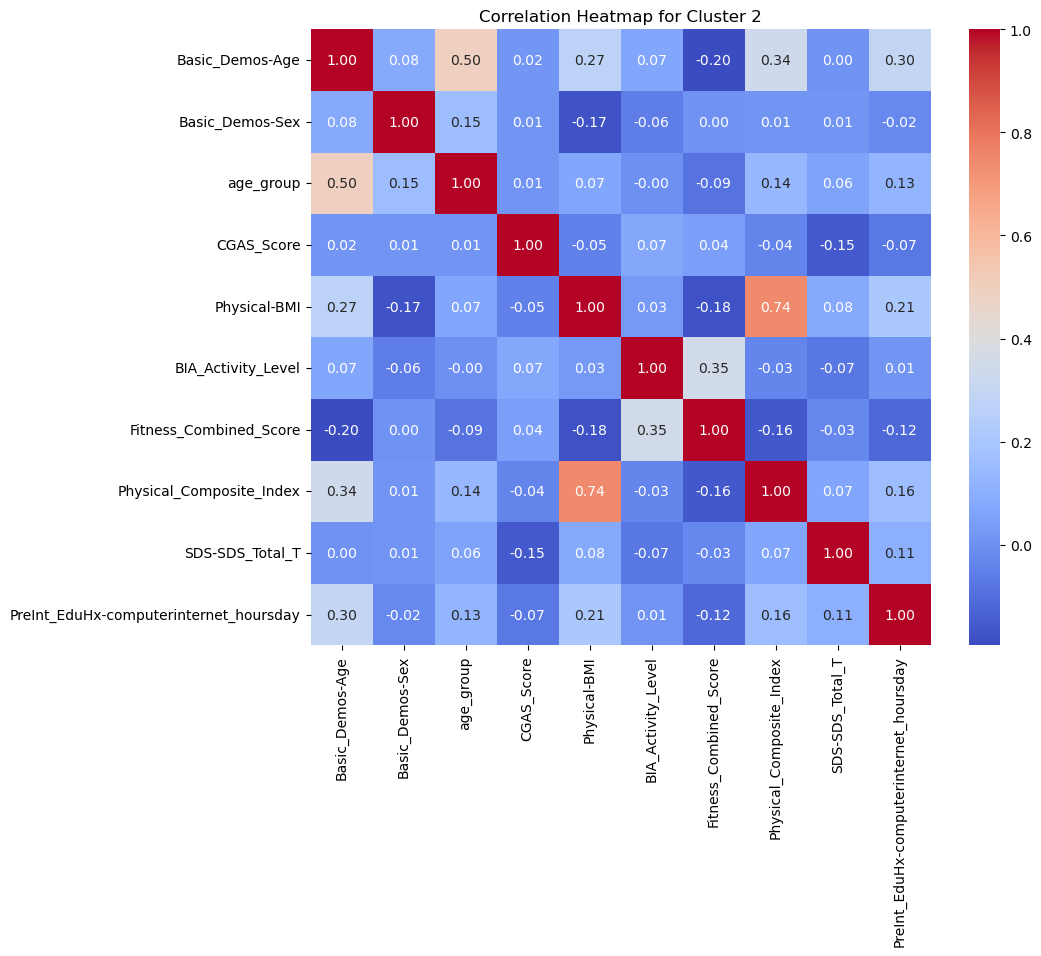

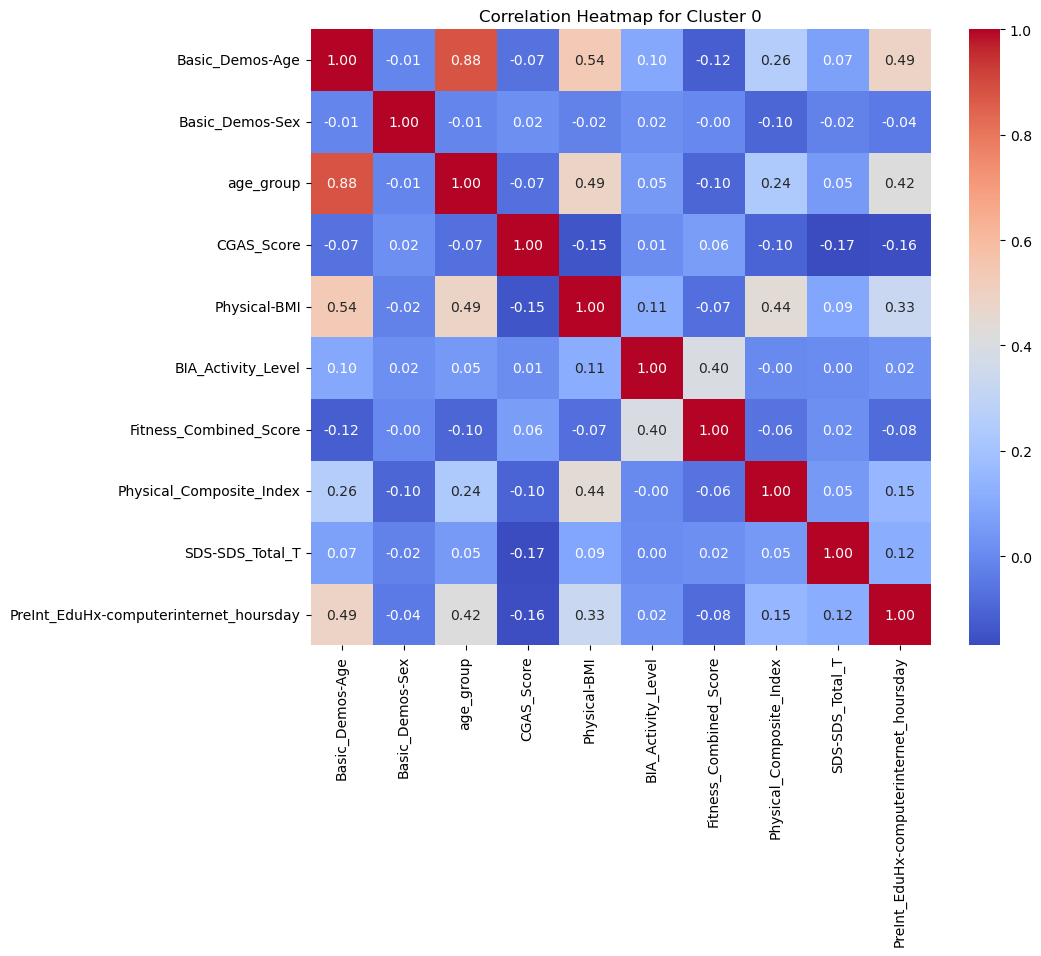

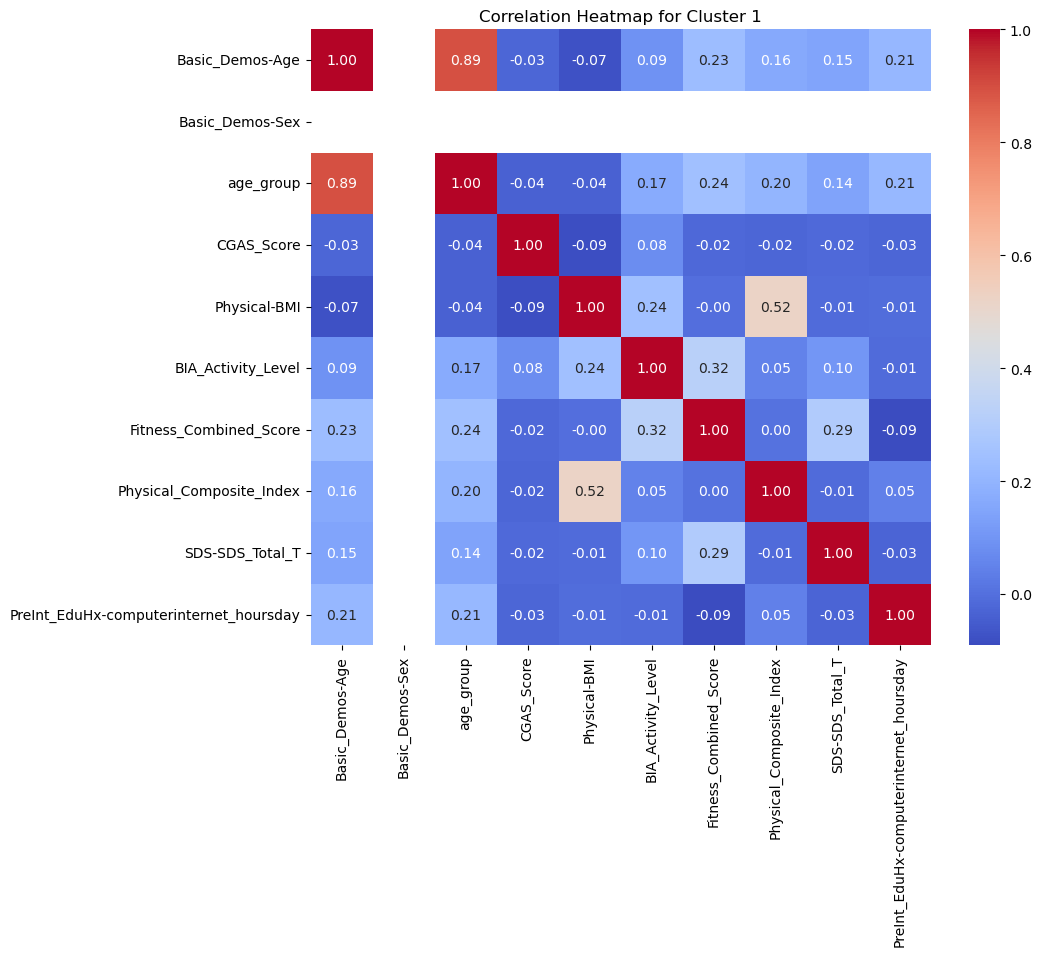

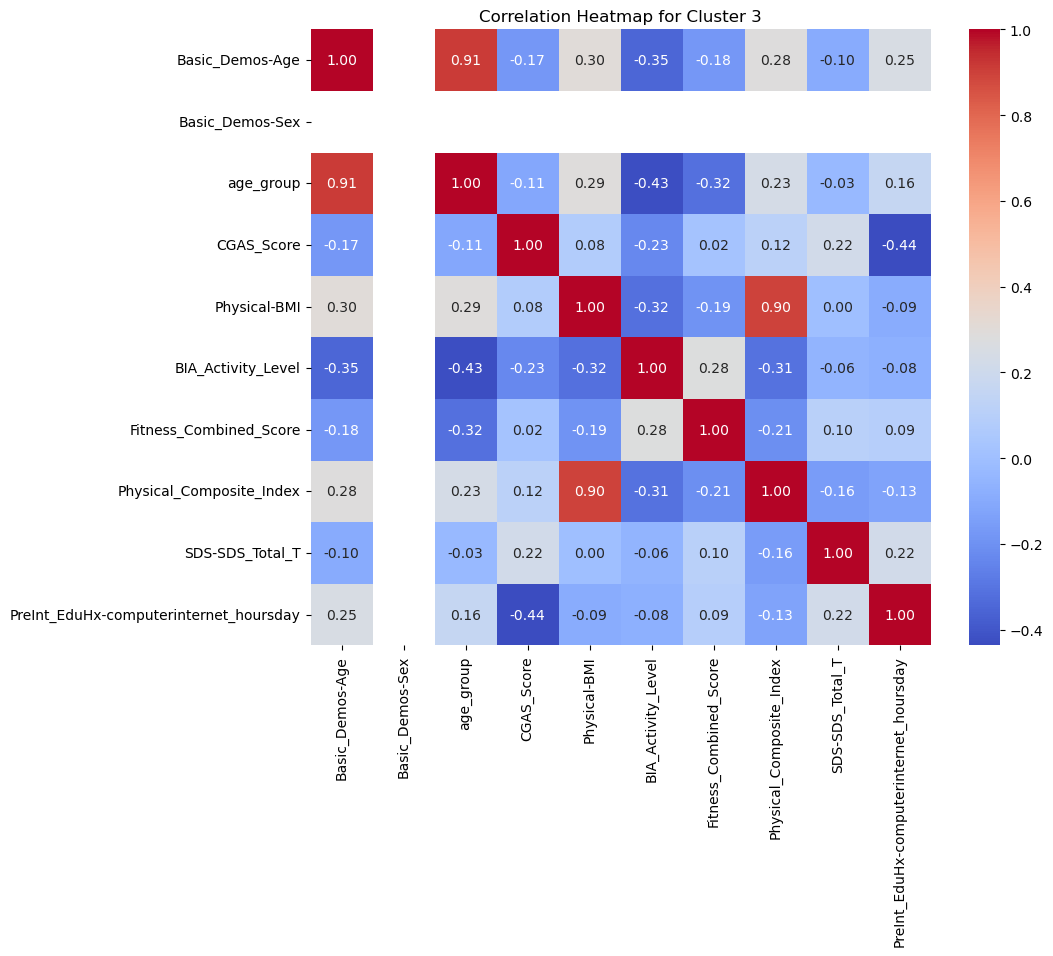

In [20]:
# Plot a correlation heatmap for each cluster
for cluster in clustered_data['Cluster'].unique():
    cluster_data = clustered_data[clustered_data['Cluster'] == cluster].drop(columns=['Cluster'])
    correlation_matrix = cluster_data.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'Correlation Heatmap for Cluster {cluster}')
    plt.show()


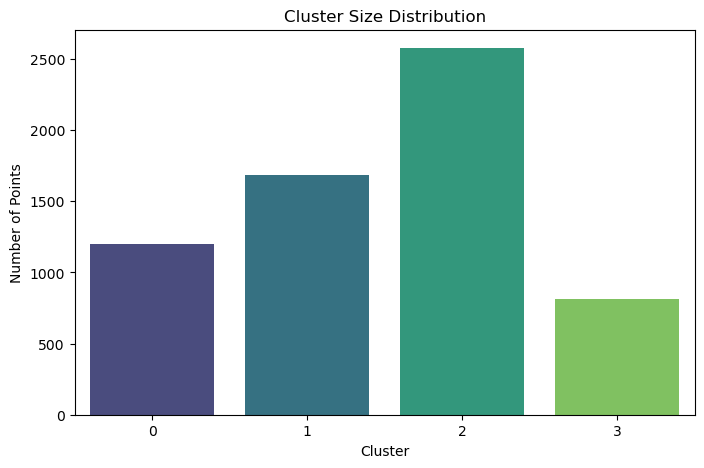

In [21]:
# Distribution of points per cluster
cluster_sizes = clustered_data['Cluster'].value_counts()

# Plot distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, palette='viridis')
plt.title('Cluster Size Distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of Points')
plt.show()
